In [1]:
# Data Management
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# Data splitting
from sklearn.model_selection import train_test_split

# Hyperparameter selection
from sklearn.model_selection import GridSearchCV

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, RFE

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from statsmodels.discrete.discrete_model import Logit
import statsmodels.tools as sm

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
import itertools

# Time Tracking
import time
t0 = time.time()

In [2]:
# Data Cleaning

data = pd.read_csv('Surgery_Data.csv')

def data_cleaning(data):

    # converting into binary variables
    data[['Risk1Yr', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32']] = \
    (data[[ 'Risk1Yr', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32']] == 'T').astype(int)

    # converting into categorical variables
    #data['DGN'] = data.DGN.str[-1:].astype(int)
    #data['PRE6'] = data.replace(['PRZ0', 'PRZ1', 'PRZ2'], [1, 2, 3])
    data['PRE14'] = data.PRE14.str[-1:].astype(int)

    # renaming data variables
    col_names = {'Risk1Yr': 'Death_1yr', 'DGN': 'Diagnosis', 'PRE4': 'FVC', 'PRE5': 'FEV1', 'PRE6': 'Performance', 
                'PRE7': 'Pain', 'PRE8': 'Haemoptysis', 'PRE9': 'Dyspnoea', 'PRE10': 'Cough', 'PRE11': 'Weakness',
                'PRE14': 'Tumor_Size', 'PRE17': 'Diabetes_Mellitus', 'PRE19': 'MI_6mo', 'PRE25': 'PAD',
                'PRE30': 'Smoking', 'PRE32': 'Asthma', 'AGE': 'Age'}
    data = data.rename(index=str, columns=col_names)

    df = data[data.Age > 30]
    df = data[data.FEV1 < 8]

    print('The original data contains \033[1m' + str(len(data)) + '\033[0m observations, while after the applied changes there are \033[1m' + str(len(df)) + '\033[0m left.')
    
    return df

data = data_cleaning(data)

# Performance: replace values to be 1-3 (Good-Poor)
data = data.replace(['PRZ0', 'PRZ1', 'PRZ2'], [1, 2, 3])

data.head()

The original data contains 471 observations, while after the applied changes there are 456 left.


,Death_1yr,Diagnosis,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_Size,Diabetes_Mellitus,MI_6mo,PAD,Smoking,Asthma,Age
0,0,DGN2,2.88,2.16,2,0,0,0,1,1,4,0,0,0,1,0,60
1,0,DGN3,3.40,1.88,1,0,0,0,0,0,2,0,0,0,1,0,51
2,0,DGN3,2.76,2.08,2,0,0,0,1,0,1,0,0,0,1,0,59
3,0,DGN3,3.68,3.04,1,0,0,0,0,0,1,0,0,0,0,0,54
4,1,DGN3,2.44,0.96,3,0,1,0,1,1,1,0,0,0,1,0,73


In [3]:
data.Diagnosis.value_counts()

DGN3    342
DGN2     49
DGN4     45
DGN5     13
DGN6      4
DGN8      2
DGN1      1
Name: Diagnosis, dtype: int64

As Diagnosis is a feature with 7 categories, it was splitted into dummies and only top three of them are left to be used in models.

In [4]:
# Diagnosis: get dummies and keep only significant ones
diag = pd.get_dummies(data.Diagnosis)

diag = diag.drop('DGN1', axis = 1)
#diag = diag.drop('DGN2', axis = 1)
#diag = diag.drop('DGN4', axis = 1)
diag = diag.drop('DGN5', axis = 1)
diag = diag.drop('DGN6', axis = 1)
diag = diag.drop('DGN8', axis = 1)
diag.head()

# Dropping department as we don't need it any more
data = data.drop('Diagnosis', axis=1)

# Joining the dummy vars of departments to our main data
data = data.join(diag)

data.head()

,Death_1yr,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_Size,Diabetes_Mellitus,MI_6mo,PAD,Smoking,Asthma,Age,DGN2,DGN3,DGN4
0,0,2.88,2.16,2,0,0,0,1,1,4,0,0,0,1,0,60,1,0,0
1,0,3.40,1.88,1,0,0,0,0,0,2,0,0,0,1,0,51,0,1,0
2,0,2.76,2.08,2,0,0,0,1,0,1,0,0,0,1,0,59,0,1,0
3,0,3.68,3.04,1,0,0,0,0,0,1,0,0,0,0,0,54,0,1,0
4,1,2.44,0.96,3,0,1,0,1,1,1,0,0,0,1,0,73,0,1,0


In [5]:
y = data.Death_1yr

# LR

In [6]:
X = data.drop('Death_1yr', axis=1)

model = LogisticRegression(class_weight='balanced', random_state=111)
model.fit(X, data.Death_1yr)

print('\033[1m Default Logistic Regression \033[0m')
feature_importances = model.coef_[0]
feature_list = list(X)
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])
feature_coeff = relative_importances.sort_values(by="importance", ascending=False)

feature_coeff

 Default Logistic Regression 


,importance
Dyspnoea,1.027173
Smoking,0.887783
Pain,0.800512
Diabetes_Mellitus,0.763977
Tumor_Size,0.590835
Weakness,0.478459
Cough,0.345315
Haemoptysis,0.250235
PAD,0.083949
Age,-0.004431


**Statsmodel for the whole data**

In [7]:
# Building model for the whole data (no splitting here)
X = data.drop(['Death_1yr'], axis=1)
#X = data[['Dyspnoea', 'Tumor_Size', 'Diabetes_Mellitus', 'Smoking', 'DGN2', 'DGN3', 'DGN4']]

model_stat = Logit.from_formula(formula='Death_1yr~'+'+'.join(X.columns),data=data)
results_stat = model_stat.fit()

results_stat.summary()

         Current function value: 0.373531
         Iterations: 35


C:\Users\Anna\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Death_1yr   No. Observations:                  456
Model:                          Logit   Df Residuals:                      437
Method:                           MLE   Df Model:                           18
Date:                Sat, 11 May 2019   Pseudo R-squ.:                  0.1211
Time:                        19:05:28   Log-Likelihood:                -170.33
converged:                      False   LL-Null:                       -193.79
                                        LLR p-value:                 0.0002171
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.4155      1.634     -0.254      0.799      -3.618       2.787
FVC                   0.0641      0.354      0.181      0.856      -0.630       0.758
FEV1                 -0.3889      0.418     -0.931      0.352      -1.208       0.430
Performance          -0.2338      0.398     -0.588      0.557      -1.014       0.546
Pain                  0.8667      0.541      1.602      0.109      -0.193       1.927
Haemoptysis           0.2397      0.387      0.619      0.536      -0.519       0.999
Dyspnoea              1.1883      0.491      2.420      0.016       0.226       2.151
Cough                 0.5600      0.450      1.245      0.213      -0.322       1.442
Weakness              0.6180      0.380      1.625      0.104      -0.128       1.364
Tumor_Size            0.5331      0.186      2.864      0.004       0.168       0.898
Diabetes_Mellitus     0.8823      0.439      2.009      0.045       0.021       1.743
MI_6mo              -22.3600   1.11e+05     -0.000      1.000   -2.18e+05    2.18e+05
PAD                  -0.0412      0.980     -0.042      0.967      -1.962       1.880
Smoking               0.8499      0.469      1.813      0.070      -0.069       1.769
Asthma              -16.5832   9571.462     -0.002      0.999   -1.88e+04    1.87e+04
Age                  -0.0139      0.018     -0.791      0.429      -0.048       0.020
DGN2                 -1.5451      0.642     -2.406      0.016      -2.804      -0.286
DGN3                 -2.0245      0.544     -3.722      0.000      -3.091      -0.958
DGN4                 -1.6008      0.664     -2.412      0.016      -2.901      -0.300
=====================================================================================
"""

In [8]:
# Dropping almost all insignificant features and rerunning the same model as above
#X = data.drop(['Death_1yr'], axis=1)
X = data[['Dyspnoea', 'Weakness', 'Tumor_Size', 'Diabetes_Mellitus', 'DGN2', 'DGN3', 'DGN4']]

model_stat = Logit.from_formula(formula='Death_1yr~'+'+'.join(X.columns),data=data)
results_stat = model_stat.fit()

results_stat.summary()

Optimization terminated successfully.
         Current function value: 0.387261
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Death_1yr   No. Observations:                  456
Model:                          Logit   Df Residuals:                      448
Method:                           MLE   Df Model:                            7
Date:                Sat, 11 May 2019   Pseudo R-squ.:                 0.08876
Time:                        19:05:28   Log-Likelihood:                -176.59
converged:                       True   LL-Null:                       -193.79
                                        LLR p-value:                 1.447e-05
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.6403      0.566     -2.896      0.004      -2.750      -0.530
Dyspnoea              1.1500      0.470      2.446      0.014       0.229       2.071
Weakness              0.6402      0.329      1.948      0.051      -0.004       1.284
Tumor_Size            0.5852      0.181      3.241      0.001       0.231       0.939
Diabetes_Mellitus     0.9058      0.423      2.143      0.032       0.077       1.734
DGN2                 -1.2218      0.610     -2.004      0.045      -2.417      -0.027
DGN3                 -1.6683      0.504     -3.308      0.001      -2.657      -0.680
DGN4                 -1.3302      0.632     -2.103      0.035      -2.570      -0.091
=====================================================================================
"""

In [9]:
results_stat.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:              Death_1yr
Method:                          dydx
At:                           overall
=====================================================================================
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Dyspnoea              0.1345      0.054      2.475      0.013       0.028       0.241
Weakness              0.0749      0.038      1.958      0.050   -7.49e-05       0.150
Tumor_Size            0.0684      0.021      3.305      0.001       0.028       0.109
Diabetes_Mellitus     0.1059      0.049      2.164      0.030       0.010       0.202
DGN2                 -0.1429      0.071     -2.026      0.043      -0.281      -0.005
DGN3                 -0.1951      0.057     -3.400      0.001      -0.308      -0.083
DGN4                 -0.1556      0.073     -2.131      0.033      -0.299      -0.013
=====================================================================================
"""

**Testing the model with splitted data**

In [10]:
# Adding constant term to X
X_const = sm.add_constant(X)

# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X_const, y, test_size=.2, stratify=y, random_state=111)

model = Logit(y_train, x_train)
results = model.fit()

print('Time taken :' , time.time()-t0)
results.summary()

Optimization terminated successfully.
         Current function value: 0.401862
         Iterations 6
Time taken : 1.1996984481811523


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Death_1yr   No. Observations:                  364
Model:                          Logit   Df Residuals:                      356
Method:                           MLE   Df Model:                            7
Date:                Sat, 11 May 2019   Pseudo R-squ.:                 0.05358
Time:                        19:05:28   Log-Likelihood:                -146.28
converged:                       True   LL-Null:                       -154.56
                                        LLR p-value:                   0.02046
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.6443      0.664     -2.475      0.013      -2.946      -0.342
Dyspnoea              0.4746      0.602      0.788      0.431      -0.706       1.655
Weakness              0.2525      0.384      0.658      0.510      -0.499       1.004
Tumor_Size            0.4713      0.204      2.314      0.021       0.072       0.871
Diabetes_Mellitus     0.8831      0.462      1.910      0.056      -0.023       1.790
DGN2                 -0.7266      0.699     -1.039      0.299      -2.097       0.644
DGN3                 -1.3090      0.594     -2.203      0.028      -2.474      -0.144
DGN4                 -0.8335      0.703     -1.185      0.236      -2.212       0.545
=====================================================================================
"""

It's with constant and l1 penalty

In [11]:
results.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:              Death_1yr
Method:                          dydx
At:                           overall
=====================================================================================
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Dyspnoea              0.0577      0.073      0.789      0.430      -0.086       0.201
Weakness              0.0307      0.047      0.658      0.510      -0.061       0.122
Tumor_Size            0.0573      0.025      2.338      0.019       0.009       0.105
Diabetes_Mellitus     0.1074      0.056      1.926      0.054      -0.002       0.217
DGN2                 -0.0883      0.085     -1.042      0.297      -0.254       0.078
DGN3                 -0.1591      0.071     -2.230      0.026      -0.299      -0.019
DGN4                 -0.1013      0.085     -1.191      0.234      -0.268       0.065
=====================================================================================
"""

In [12]:
# Compareing predicted and actual values of y when threshold is 0.5
y_probab = results.predict(x_test)
predictions_table = pd.DataFrame(y_probab, columns=(['Probabilities']))
predictions_table['y_pred'] = np.where(predictions_table.Probabilities>=0.5, 1, 0)
predictions_table['y_true'] = y_test

predictions_table[10:20]

,Probabilities,y_pred,y_true
208,0.118101,0,0
423,0.118101,0,0
434,0.077138,0,0
396,0.118101,0,0
328,0.118101,0,0
350,0.118101,0,1
439,0.097140,0,0
168,0.168156,0,0
238,0.284864,0,1
360,0.118101,0,0


In [13]:
type(predictions_table.y_pred[0])

numpy.int32

In [14]:
# scores
acc = accuracy_score(predictions_table.y_true, predictions_table.y_pred)
roc_auc = roc_auc_score(y_test, y_probab)
recall = recall_score(predictions_table.y_true, predictions_table.y_pred)
precision = precision_score(predictions_table.y_true, predictions_table.y_pred)

scores_lr = pd.DataFrame({'Accuracy': acc, 'ROC_AUC': roc_auc,
                       'Recall': recall, 'Precision': precision}, index=['Logistic Regression'])

scores_lr.transpose()

,Logistic Regression
Accuracy,0.858696
ROC_AUC,0.813645
Recall,0.071429
Precision,1.000000



  Classification Report 
               precision    recall  f1-score   support

   Survived       0.86      1.00      0.92        78
       Died       1.00      0.07      0.13        14

avg / total       0.88      0.86      0.80        92



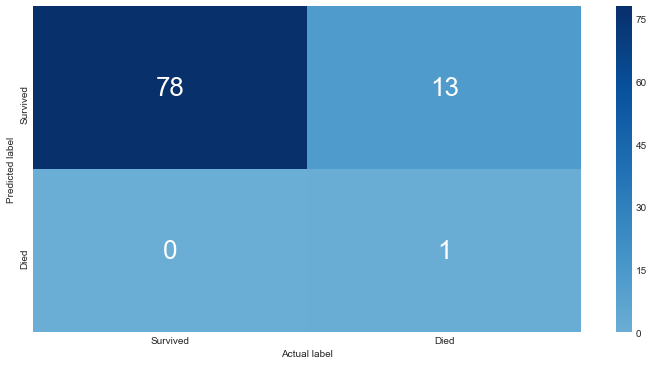

In [15]:
# Building confussion martix
classes = ['Survived', 'Died']

print('\n \033[1m Classification Report \n \033[0m', classification_report(y_test, predictions_table.y_pred, target_names=classes))

cnf_matrix_lr = confusion_matrix(y_test, predictions_table.y_pred).T
plt.figure(figsize=(10,5))
sns.heatmap(cnf_matrix_lr, cmap=plt.cm.Blues, center=0, annot=True, annot_kws={'size': 26}, xticklabels=classes, yticklabels=classes);


plt.tight_layout()
plt.xlabel('Actual label')
plt.ylabel('Predicted label')

plt.show()

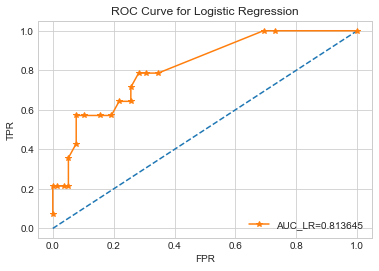

In [16]:
# Plotting ROC Curve for splited data
FPR,TPR,thresholds=roc_curve(y_test,predictions_table.Probabilities)

plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='AUC_LR=%f'%roc_auc_score(y_test,predictions_table.Probabilities), marker='*')

plt.legend(loc='lower right')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Logistic Regression')

plt.show()

# DT

In [17]:
X = data.drop('Death_1yr', axis=1)

model = DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=111)
model.fit(X, y)

feature_importances = model.feature_importances_
feature_list = list(X)
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])
relative_importances.sort_values(by="importance", ascending=False)

selected_features = relative_importances[relative_importances.importance>0]
selected_list = selected_features.index

selected_features

,importance
FVC,0.126140
Cough,0.197279
Tumor_Size,0.234562
Smoking,0.292723
Age,0.149296


In [18]:
# Defining y and X
X = data[selected_list]
#X = data[['Dyspnoea', 'Weakness', 'Tumor_Size', 'Diabetes_Mellitus', 'DGN2', 'DGN3', 'DGN4']]

# Splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=111)

# Defining model to be used
model_dt = model
model_dt.fit(x_train,y_train)

# predict, predict_proba
y_pred_dt = model_dt.predict(x_test)
probab_dt = model_dt.predict_proba(x_test)[:, 1]

# scores
acc = accuracy_score(y_test, y_pred_dt)
roc_auc = roc_auc_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt)

scores_dt = pd.DataFrame({'Accuracy': acc, 'ROC_AUC': roc_auc,
                       'Recall': recall, 'Precision': precision}, index=['Decision Tree'])

scores_dt.transpose()

,Decision Tree
Accuracy,0.750000
ROC_AUC,0.618132
Recall,0.428571
Precision,0.285714



  Classification Report 
               precision    recall  f1-score   support

   Survived       0.89      0.81      0.85        78
       Died       0.29      0.43      0.34        14

avg / total       0.80      0.75      0.77        92



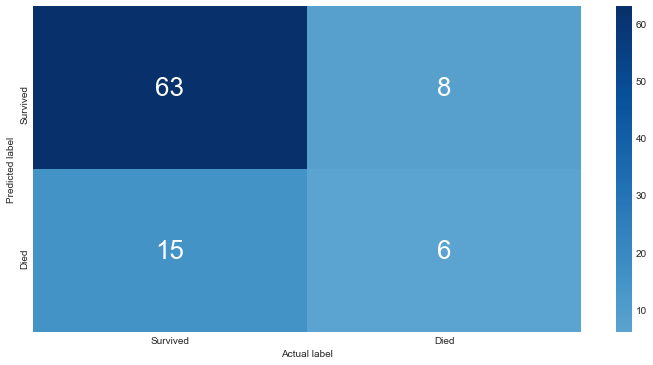

In [19]:
# Building confussion martix
classes = ['Survived', 'Died']

print('\n \033[1m Classification Report \n \033[0m', classification_report(y_test, y_pred_dt, target_names=classes))

cnf_matrix_dt = confusion_matrix(y_test, y_pred_dt).T
plt.figure(figsize=(10,5))
sns.heatmap(cnf_matrix_dt, cmap=plt.cm.Blues, center=0, annot=True, annot_kws={'size': 26}, xticklabels=classes, yticklabels=classes);


plt.tight_layout()
plt.xlabel('Actual label')
plt.ylabel('Predicted label')

plt.show()

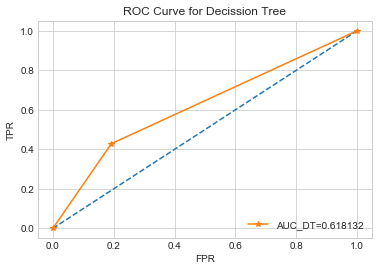

In [20]:
# Plotting ROC Curve for splited data
FPR,TPR,thresholds=roc_curve(y_test,y_pred_dt)

plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='AUC_DT=%f'%roc_auc_score(y_test,y_pred_dt), marker='*')

plt.legend(loc='lower right')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Decission Tree')

plt.show()

In [21]:
# Defining y and X
y = data.Death_1yr
#X = data[['FVC', 'Cough', 'Tumor_Size', 'Smoking', 'Age']]
X = data[['Dyspnoea', 'Weakness', 'Tumor_Size', 'Diabetes_Mellitus', 'DGN2', 'DGN3', 'DGN4']]
#X = data[['FVC', 'FEV1', 'Dyspnoea', 'Tumor_Size', 'Diabetes_Mellitus', 'DGN2', 'DGN3', 'DGN4']]

# Splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=111)

# Defining model to be used
model_sk = model
model_sk.fit(x_train,y_train)

# predict, predict_proba
y_pred_sk = model_sk.predict(x_test)
probab_sk = model_sk.predict_proba(x_test)[:, 1]

# scores
acc = accuracy_score(y_test, y_pred_sk)
roc_auc = roc_auc_score(y_test, y_pred_sk)
recall = recall_score(y_test, y_pred_sk)
precision = precision_score(y_test, y_pred_sk)

scores = pd.DataFrame({'Accuracy': acc, 'ROC_AUC': roc_auc,
                       'Recall': recall, 'Precision': precision}, index=['DT with Logit features'])

scores.transpose()

,DT with Logit features
Accuracy,0.739130
ROC_AUC,0.611722
Recall,0.428571
Precision,0.272727


# RF

In [22]:
X = data.drop('Death_1yr', axis=1)

model = RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=111)
model.fit(X, y)

feature_importances = model.feature_importances_
feature_list = list(X)
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])
relative_importances.sort_values(by="importance", ascending=False)

selected_features = relative_importances[relative_importances.importance>0.01]
selected_list = selected_features.index

selected_features

,importance
FVC,0.278202
FEV1,0.180155
Performance,0.037761
Haemoptysis,0.016469
Dyspnoea,0.047740
Cough,0.014558
Weakness,0.030952
Tumor_Size,0.106572
Diabetes_Mellitus,0.024208
Smoking,0.080730


In [23]:
# Defining y and X
X = data[selected_list]
#X = data[['Dyspnoea', 'Weakness', 'Tumor_Size', 'Diabetes_Mellitus', 'DGN2', 'DGN3', 'DGN4']]

# Splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=111)

# Defining model to be used
model_rf = model
model_rf.fit(x_train,y_train)

# predict, predict_proba
y_pred_rf = model_rf.predict(x_test)
probab_rf = model_rf.predict_proba(x_test)[:, 1]

# scores
acc = accuracy_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)

scores_rf = pd.DataFrame({'Accuracy': acc, 'ROC_AUC': roc_auc,
                       'Recall': recall, 'Precision': precision}, index=['Random Forest'])

scores_rf.transpose()

,Random Forest
Accuracy,0.728261
ROC_AUC,0.605311
Recall,0.428571
Precision,0.260870



  Classification Report 
               precision    recall  f1-score   support

   Survived       0.88      0.78      0.83        78
       Died       0.26      0.43      0.32        14

avg / total       0.79      0.73      0.75        92



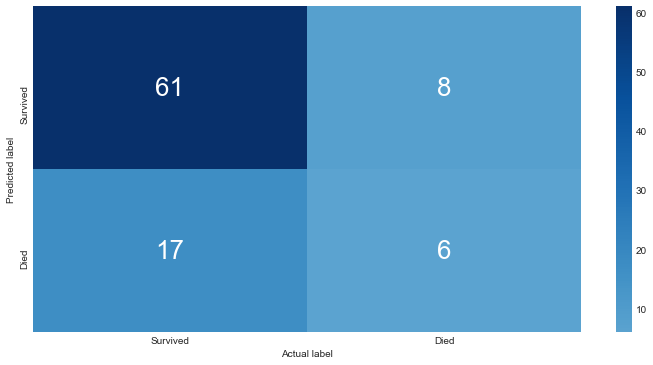

In [24]:
# Building confussion martix
classes = ['Survived', 'Died']

print('\n \033[1m Classification Report \n \033[0m', classification_report(y_test, y_pred_rf, target_names=classes))

cnf_matrix_rf = confusion_matrix(y_test, y_pred_rf).T
plt.figure(figsize=(10,5))
sns.heatmap(cnf_matrix_rf, cmap=plt.cm.Blues, center=0, annot=True, annot_kws={'size': 26}, xticklabels=classes, yticklabels=classes);


plt.tight_layout()
plt.xlabel('Actual label')
plt.ylabel('Predicted label')

plt.show()

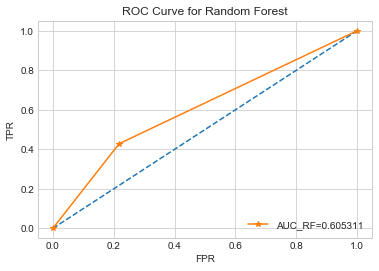

In [25]:
# Plotting ROC Curve for splited data
FPR,TPR,thresholds=roc_curve(y_test,y_pred_rf)

plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='AUC_RF=%f'%roc_auc_score(y_test,y_pred_rf), marker='*')

plt.legend(loc='lower right')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Random Forest')

plt.show()

In [26]:
# Defining y and X
y = data.Death_1yr
#X = data[['FVC', 'Cough', 'Tumor_Size', 'Smoking', 'Age']]
X = data[['Dyspnoea', 'Tumor_Size', 'Weakness', 'Diabetes_Mellitus', 'DGN2', 'DGN3', 'DGN4']]

# Splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=111)

# Defining model to be used
model_sk = model
model_sk.fit(x_train,y_train)

# predict, predict_proba
y_pred_sk = model_sk.predict(x_test)
probab_sk = model_sk.predict_proba(x_test)[:, 1]

# scores
acc = accuracy_score(y_test, y_pred_sk)
roc_auc = roc_auc_score(y_test, y_pred_sk)
recall = recall_score(y_test, y_pred_sk)
precision = precision_score(y_test, y_pred_sk)

scores = pd.DataFrame({'Accuracy': acc, 'ROC_AUC': roc_auc,
                       'Recall': recall, 'Precision': precision}, index=["model"])

scores.transpose()

,model
Accuracy,0.728261
ROC_AUC,0.517399
Recall,0.214286
Precision,0.176471


# NB

In [27]:
# NB
model = GaussianNB()


y = data.Death_1yr
#X = data[['FVC', 'Cough', 'Tumor_Size', 'Smoking', 'Age']]
X = data[['Dyspnoea', 'Tumor_Size', 'Weakness', 'Diabetes_Mellitus', 'DGN2', 'DGN3', 'DGN4']]

# Splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=111)

# Defining model to be used
model_nb = model
model_nb.fit(x_train,y_train)

# predict, predict_proba
y_pred_nb = model_nb.predict(x_test)
probab_nb = model_nb.predict_proba(x_test)[:, 1]

# scores
acc = accuracy_score(y_test, y_pred_nb)
roc_auc = roc_auc_score(y_test, y_pred_nb)
recall = recall_score(y_test, y_pred_nb)
precision = precision_score(y_test, y_pred_nb)

scores_nb = pd.DataFrame({'Accuracy': acc, 'ROC_AUC': roc_auc,
                       'Recall': recall, 'Precision': precision}, index=['Gaussian Naive Bayes'])

scores_nb.transpose()

,Gaussian Naive Bayes
Accuracy,0.847826
ROC_AUC,0.705128
Recall,0.500000
Precision,0.500000



  Classification Report 
               precision    recall  f1-score   support

   Survived       0.91      0.91      0.91        78
       Died       0.50      0.50      0.50        14

avg / total       0.85      0.85      0.85        92



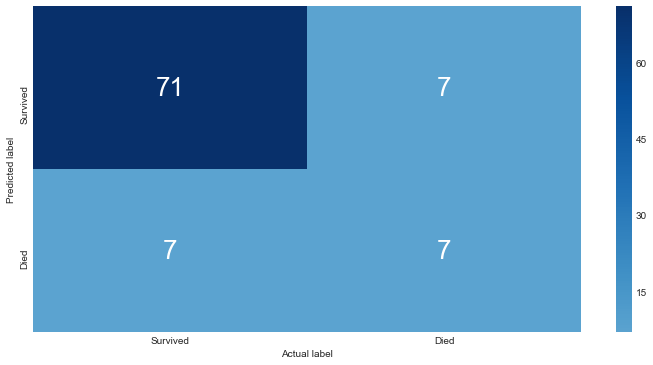

In [28]:
# Building confussion martix
classes = ['Survived', 'Died']

print('\n \033[1m Classification Report \n \033[0m', classification_report(y_test, y_pred_nb, target_names=classes))

cnf_matrix_nb = confusion_matrix(y_test, y_pred_nb).T
plt.figure(figsize=(10,5))
sns.heatmap(cnf_matrix_nb, cmap=plt.cm.Blues, center=0, annot=True, annot_kws={'size': 26}, xticklabels=classes, yticklabels=classes);


plt.tight_layout()
plt.xlabel('Actual label')
plt.ylabel('Predicted label')

plt.show()

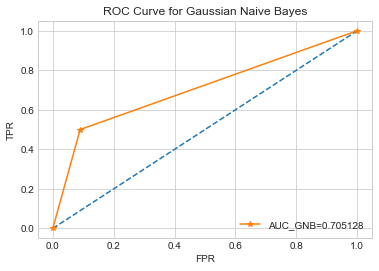

In [29]:
# Plotting ROC Curve for splited data
FPR,TPR,thresholds=roc_curve(y_test,y_pred_nb)

plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='AUC_GNB=%f'%roc_auc_score(y_test,y_pred_nb), marker='*')

plt.legend(loc='lower right')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Gaussian Naive Bayes')

plt.show()

# Summary

In [30]:
scores_lr.T.join([scores_nb.T, scores_dt.T, scores_rf.T])

,Logistic Regression,Gaussian Naive Bayes,Decision Tree,Random Forest
Accuracy,0.858696,0.847826,0.750000,0.728261
ROC_AUC,0.813645,0.705128,0.618132,0.605311
Recall,0.071429,0.500000,0.428571,0.428571
Precision,1.000000,0.500000,0.285714,0.260870


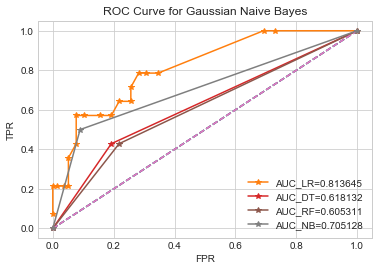

In [31]:
# Plotting ROC Curves

# LR
FPR,TPR,thresholds=roc_curve(y_test,predictions_table.Probabilities)

plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='AUC_LR=%f'%roc_auc_score(y_test,predictions_table.Probabilities), marker='*')

# DT
FPR,TPR,thresholds=roc_curve(y_test,y_pred_dt)

plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='AUC_DT=%f'%roc_auc_score(y_test,y_pred_dt), marker='*')

# RF
FPR,TPR,thresholds=roc_curve(y_test,y_pred_rf)

plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='AUC_RF=%f'%roc_auc_score(y_test,y_pred_rf), marker='*')

# NB
FPR,TPR,thresholds=roc_curve(y_test,y_pred_nb)

plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='AUC_NB=%f'%roc_auc_score(y_test,y_pred_nb), marker='*')


plt.legend(loc='lower right')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Gaussian Naive Bayes')

plt.show()